In [2]:
import random
from random import choice, sample
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#random.seed(22)
#Randomly generate a single sequence with a motif
def generate_sequence(max_length, min_length, num_mutations, motif):
  dna_seq = ""

  length = random.randint(min_length, max_length)
  for count in range(length):
    dna_seq += choice("CGTA")

  motif_pos = random.randint(0, len(dna_seq)-1)
  mutated_motif = get_mutated_motif(num_mutations, motif)
  dna_seq_motif = dna_seq[:motif_pos] + mutated_motif + dna_seq[motif_pos:]
  return dna_seq_motif, mutated_motif, motif_pos

#generate multiple sequences with motif of length l
def generate_multiple_sequences(max_length, min_length, num_sequences, num_mutations, motif_length):
  motif = get_single_motif(motif_length)
  dna_seqs = []
  mut_motifs = []
  motif_positions = []
  for count in range(num_sequences):
    seq, mut_motif, motif_pos = generate_sequence(max_length, min_length, num_mutations, motif)
    dna_seqs.append(seq)
    mut_motifs.append(mut_motif)
    motif_positions.append(motif_pos)
  #print(dna_seqs)
  return dna_seqs, mut_motifs, motif_positions


#randomly generates a motif and then introduces mutations by replaces given number of characters in a motif
def get_mutated_motif(num_mutations, motif):
  mutation_pos = random.sample(range(len(motif)), num_mutations)
  for i in range(len(motif)):
    for pos in mutation_pos:
      if pos == i:
        mutation = choice("CGTA")
        motif = motif[:pos] + mutation + motif[pos+1:]
  return motif

def get_single_motif(motif_legnth):
  motif = ""
  for count in range(motif_legnth):
    motif += choice("CGTA")
  return motif



max_seq_length = 500
min_seq_length = 100
num_sequences = 50
num_motif_mutations = 2
motif_legnth = 12


random_seqs, mut_motifs, motif_pos= generate_multiple_sequences(max_seq_length, min_seq_length, num_sequences, num_motif_mutations, motif_legnth)


##Download and Process TAIR10 Dataset

In [8]:
import re
# fasta_file = "/content/FunBioTermProject_data/TAIR10_upstream_500_20101028.fasta"
# fasta_file = '/content/TAIR10_upstream_500_20101028.fasta'
fasta_file = "/content/drive/MyDrive/Colab Notebooks/TAIR10_upstream_500.fasta"

def get_seqs (fasta_file):
  open_fasta = open(fasta_file)

  # Dictionary of genes and sequences. Key is the gene and value is the
  # information in array as: [location, orientation, length, sequence].
  seq_dict = {}
  seq = []

  for i, line in enumerate(open_fasta):
    if line.startswith('>'):

      # Error handling on first iteration.
      if i !=0:
        seq_dict[gene_info[0]] = [gene_info[1], gene_info[2], gene_info[3], ''.join(seq)]

      seq.clear()
      gene = re.split(r'\s+', line)
      gene_info = [gene[0][1:], gene[2], gene[3], re.split(r'=',gene[4])[1]]

    else:
      seq.append(line.strip())

  # This is for the very last gene that will have everything prepped, but
  # will not be added to the dictionary because enumeration ended.
  seq_dict[gene_info[0]] = [gene_info[1], gene_info[2], gene_info[3], ''.join(seq)]
  print(gene_info[0], gene_info[1], gene_info[2], gene_info[3], ''.join(seq))
  # Good practice to close file.
  open_fasta.close()

  return seq_dict

seq_dict= get_seqs (fasta_file)
print(len(seq_dict))
def make_sequences(seq_dict):
  long_seqs = []
  for i in seq_dict:
    seq = seq_dict[i][3]
    if "N" in seq:

      continue
    if "R" in seq:
      continue
    long_seqs.append(seq)
  return long_seqs

long_seqs = make_sequences(seq_dict)

#covert to Pandas table for easier processing
seq_df = df = pd.DataFrame([(k,) + tuple(v) for (k, v) in seq_dict.items()], columns=['AGI NO.', 'Chr Loc', 'F/R',"Length", "SEQUENCE"])

ATMG00930 chrM:250154-250653 REVERSE 500 AGTGAACTTTCACAATTTCTGATGAGACCTTAGATAGAAAAGAAGGTTTAGATTAAAGTTTCTATTCCTTCCTATTAAACGCTTTCAAAAGATTGTTGAGATATCTTCTCTGAATTGTCTGCACTTGACACCTTCCTCTCAACTTGCTCTTGTTTTAGTGATGCTGATTGGCCTTCGTGGGAATTTATAGATCACTCTCAGGATATTGGCTTTTTCTTGGGAGATCTACGGGAAAAGAAGGAAAGAAGTCAAAATAAGAGAGTAAGAGCCTAGGTTAGAAGTCAGTTTCAGTTCTCTTAGGTCTCTTTCCACATATACAAACTGAGAGTTCAGTCTCATATAGCATGAGGGGACATGGCTTGGTAATCGATTCAAATTGGACATAGATAATCTTTCAATTTCTCATATTATATATGATAATATAGGCGTGGAAAATTTATTGGGGTTATAAAAAAAAAAAGAATCCTCGTCTTTACAGTCTTATCAATTGTGATAAGAAA
33602


In [9]:
# process 50 bp sequences from TAIR10 dataset
short_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TATA_Sequences.xlsx")

# sequences = []
# for seq in short_df["SEQUENCE"]:
#   sequences.append(seq)

# # sequences

# TATA_seqs = []
# for tata in short_df["SEQUENCE"]:
#   TATA_seqs.append(tata)


short_df.drop_duplicates('AGI NO.', keep = False, inplace = True)

#merge 500 and 50 bp sequences by aligning the AGI NO.
seq_df_merged = seq_df.merge(short_df, left_on=['AGI NO.'], right_on=['AGI NO.'], how='inner')
seq_df_merged.drop(columns = "POSITION OF TATA.1", inplace = True)
seq_df_merged.drop_duplicates('SEQUENCE_x', keep=False, inplace = True)

seq_df_merged.head(5)

,AGI NO.,Chr Loc,F/R,Length,SEQUENCE_x,SL No.,CHROMOSOME,ORIENTATION,SEQUENCE_y,POSITION OF TATA,TATA Sequence
0,AT1G08810,chr1:2820396-2820895,REVERSE,500,GTGTTTCTTCCCACACTTTATCTTTATTTATTTTCTTACCACAATT...,58,chr1:2820399-2820898,REVERSE,TTAATTTCACATATATGTACATACATGTTGCATTTAACTCATATAC...,9,TATACATA
1,AT1G08880,chr1:2847801-2848300,REVERSE,500,TGTATTTGGCAGTGACTCATTGGTCGTGTCCCATGTGAACAACTGT...,59,chr1:2847804-2848303,REVERSE,ATCTAAAGTCTAACAAATCACAATCAATCTTAGTAGCCTATACATA...,12,TATACATA
2,AT1G24520,chr1:8688129-8688628,FORWARD,500,CTATAGATCTTGGGTTTTTTTTGTTTCCTAGTGCACTGGAGAGGAA...,60,chr1:8688117-8688616,FORWARD,TGATCACAAAACACAACTATATATACATATCAAACTCATCTTCGGA...,29,TATACATA
3,AT1G70370,chr1:26515189-26515688,REVERSE,500,CTTTTTCATTTTTTTAGTCCCTACTTTATTTCTCATTCATTATCCT...,62,chr1:26518852-26519351,REVERSE,AATTATACGTTACCAACTATACATAAATTATAAATAAATTAAAAAT...,33,TATACATA
4,AT1G65450,chr1:24315314-24315813,FORWARD,500,GGGTAAAAATCGTATTATTCCATAAACCACAAATGGAGAAGTCAAA...,63,chr1:24321027-24321526,FORWARD,TCATTTTGTAAAGAAAATTATATAAACCATATACATATTACTTGAT...,21,TATACATA


# New Section

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TATA_seqs

In [10]:
def letter_to_num(letter): # symbol is a string of length 1
  if letter == "A":
    return 0
  if letter == "G":
    return 1
  if letter == "C":
    return 2
  if letter == "T":
    return 3
  raise Exception(f"No letter for symbol {letter}")


def num_to_letter(num): # x is an integer
	if num == 0:
		return "A"
	if num == 1:
		return "G"
	if num == 2:
		return "C"
	if num == 3:
		return "T"
	raise Exception(f"No letter for number {num}")


#build profile matrix with nucleic acid frequencies; Initialize "A", "T", "G", "C" counts at 1 (laplace transform) to avoid dividing by 0
def build_profile(motifs):
  k = len(motifs[0])
  profile = [[1 for i in range(k)] for j in range(4)]

  for x in motifs:
    for i in range(len(x)):
      j = letter_to_num(x[i])
      profile[j][i] += 1 # add counts of each letter in the same position in an l-mer
  for x in profile:
    for i in range(len(x)):
      x[i] = ((x[i]))/len(motifs)

  return profile

#calculate likelihood probability for the motif in the remove sequence
def best_motif_pos_removed_seq(l, profile, seq_i):
  probs = []
  for i in range(0, len(seq_i)-l + 1):
    #print("seq_i[i:i+l]", i+l, seq_i[i:i+l], seq_i)
    prob = 1.0
    motif = seq_i[i:i+l] # motifs from the removed sequence starting at position 1 through the length of the sequence
    for j in range(l):
      k = letter_to_num(motif[j])
      try:
        prob*= profile[k][j] #use probabilities from the profile to calculate probability of every possible l-mer in the removed sequence
      except Exception as e:
        print(k, j)
        print(profile)
        raise
    probs.append(prob)
  s = 0.0
  for x in probs:
    s += x

  i = random.random()
  partial = 0.0
  for x in range(len(probs)):

    partial += probs[x]

    if partial/s >= i:
      return x

def consensus_seq(profile):
  #print(profile)
  cons_seq = ""
  for i in range(len(profile[0])):
    max_freq = 0
    loc = 0
    for j in range(4): #each element in the profile (A, T, G, C)
      if profile[j][i] > max_freq: #concensus sequence based on highest frequency of each letter in the same position in a differnt motifs
        loc = j          # setting the index of the element to the location
        max_freq = profile[j][i] # if the letter in a profile has the highest frequency, set it as max

    cons_seq += num_to_letter(loc) #builds consensus sequence based on highest frequency
  #print("cons_seq", cons_seq)
  return cons_seq

#calculate the mismatch scores of the motifs
def mismatch_score(motifs):
  profile = build_profile(motifs)
  cons = consensus_seq(profile)
  mm_score = 0
  for x in motifs:
    for i in range(len(x)):
      if cons[i] !=x[i]:
        mm_score += 1
  return mm_score




def gibbs_sampler(seqs, l, n):
  motifs = []
  motif_positions = []
  #randomly picks motifs of length l from all the sequences
  for seq in seqs:
    i = random.randrange(0, len(seq)-l)
    subseq = seq[i:i+l] #subset of a sequence assigned as motif
    motifs.append(subseq)
    motif_positions.append(i)
  best_motifs = motifs[:]

  for i in range(1, n):
    j = random.randint(0, len(seqs)-1)
    motifs_with_removed_seq = build_profile(motifs[:j]+ motifs[j+1:])
    r = best_motif_pos_removed_seq(l, motifs_with_removed_seq, seqs[j]) # motif position in the removed sequence for the highest probability
    motifs[j] = seqs[j][r:r+l] #slice the subsequence for motif starting at position j

    if mismatch_score(motifs) < mismatch_score(best_motifs):
      best_motifs = motifs[:]
  return best_motifs, motif_positions

def run_gibbs_sampler(seqs,l, N, t):
  best_motif, positions = gibbs_sampler(seqs,l, N)
  s = mismatch_score(best_motif)
  mismatch_scores = []
  for x in range(t):
    # print("Iteration:", x, ", Mismatch Score =", s)
    sample, pos = gibbs_sampler(seqs,l, N)
    mismatch_scores.append((s))
    if mismatch_score(sample) < s:
      s = mismatch_score(sample)
      best_motif = sample[:]
      positions = pos[:]
  return best_motif, positions, mismatch_scores

In [11]:
#produce randomly generated sequences with varied parameter values

#Vary number of mutations in motifs
def seqs_num_mutations():
  max_seq_length = 500
  min_seq_length = 500
  num_sequences = 50
  motif_legnth = 10

  list_of_seqs = []


  for i in range(0, 8, 2):
    seqs, motifs, positions = generate_multiple_sequences(max_seq_length, min_seq_length, num_sequences, i, motif_legnth)

    list_of_seqs.append((i, seqs, motifs, positions))
  return list_of_seqs

#Vary the number of sequences in each list
def vary_seq_list_size():
  max_seq_length = 500
  min_seq_length = 500
  num_motif_mutations = 2
  motif_legnth = 10

  list_of_seqs = []


  for i in range(50, 851, 200):
    seqs, mut_motifs, positions = generate_multiple_sequences(max_seq_length, min_seq_length, i, num_motif_mutations, motif_legnth)

    list_of_seqs.append((i, seqs, mut_motifs, positions))
  return list_of_seqs

#Vary sequence legnth
def vary_seq_length():
  num_motif_mutations = 2
  motif_legnth = 10
  num_sequences = 50

  list_of_seqs = []

  for i in range(50, 551, 100):
    print(i)
    seqs, mut_motifs, positions = generate_multiple_sequences(i, i, num_sequences, num_motif_mutations, motif_legnth)

    list_of_seqs.append((i, seqs, mut_motifs, positions))
  return list_of_seqs

#Vary Motif Length
def vary_motif_length():
  max_seq_length = 500
  min_seq_length = 500
  num_sequences = 50
  num_motif_mutations = 2

  list_of_seqs = []


  for i in range(4, 24, 4):
    print(i)
    seqs, mut_motifs, positions = generate_multiple_sequences(max_seq_length, min_seq_length, num_sequences, num_motif_mutations, i)

    list_of_seqs.append((i, seqs, mut_motifs, positions))
  return list_of_seqs

In [12]:
N = 4000
t = 20

In [13]:

#Run gibbs sampler on sequences with different number of mutations
def test_num_mutations( N, t):
  seq_list = seqs_num_mutations()
  results = []
  for i, seqs, mut_motifs, pos in seq_list:
    l = len(mut_motifs[0])
    motifs, positions, scores= run_gibbs_sampler(seqs,l, N, t)
    results.append((i, motifs, positions, scores, mut_motifs, pos))
  return results


results_num_mut = test_num_mutations(N, t)



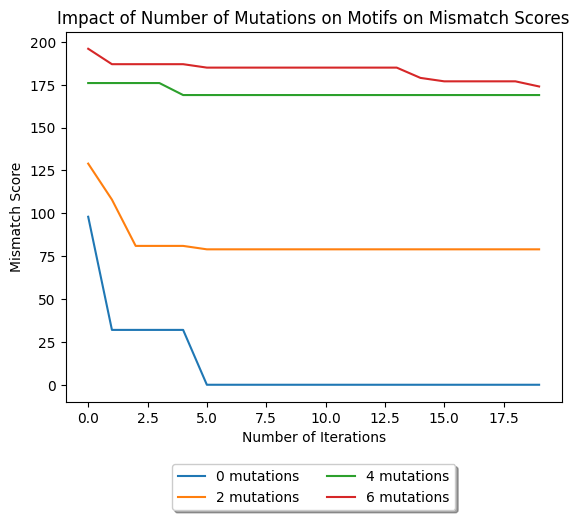


Number of Mutations in Motifs = 0
Best score from Gibb's motifs = 0
Best score from real motifs = 0
Percent Correctly Identified= 100.0 % 
number of correct 50  wrong: 0

Number of Mutations in Motifs = 2
Best score from Gibb's motifs = 79
Best score from real motifs = 76
Percent Correctly Identified= 84.0 % 
number of correct 42  wrong: 8

Number of Mutations in Motifs = 4
Best score from Gibb's motifs = 169
Best score from real motifs = 151
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 50

Number of Mutations in Motifs = 6
Best score from Gibb's motifs = 174
Best score from real motifs = 229
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 50


In [14]:
#plot mismatch score Vs number of iterations for different number of mutations in motifs and print the accuracy
def plot_num_mut():
  num_mut_lab = []
  scores = []
  for i, j, k, l, m, n in results_num_mut:
    label = str(i) + " mutations"
    num_mut_lab.append(label)
    scores.append(l)

  s = range(0,t)


  ax_1 = plt.subplot(111)

  for score, l in zip(scores, num_mut_lab):
    plt.plot(s, score, label = l)
  plt.title('Impact of Number of Mutations on Motifs on Mismatch Scores')
  plt.xlabel("Number of Iterations")
  plt.ylabel("Mismatch Score", rotation = 90)
  ax_1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=2)
  plt.show()


plot_num_mut()

for num, best_motifs, positions, scores, mut_motifs, motif_pos in results_num_mut:
  print("\nNumber of Mutations in Motifs =", num)
  print("Best score from Gibb's motifs =", mismatch_score(best_motifs))
  print("Best score from real motifs =", mismatch_score(mut_motifs))


  correct = 0
  wrong = 0

  for i in range(len(mut_motifs)):

    if mut_motifs[i] == best_motifs[i]:
      correct+=1


    else:
      wrong+=1



  print("Percent Correctly Identified=", (1-wrong/len(mut_motifs)) *100 , "%", "\nnumber of correct", correct, " wrong:", wrong)

In [15]:
#Run Gibbs sampler for different number of sequence sets

def test_size_of_seq_list(N, t):
  seq_list = vary_seq_list_size()
  results = []
  for i, seqs, mut_motifs, pos in seq_list:
    l = len(mut_motifs[0])
    motifs, positions, scores= run_gibbs_sampler(seqs,l, N, t)
    results.append((i, motifs, positions, scores, mut_motifs, pos))
  return results

results_seq_list_size = test_size_of_seq_list(N, t )



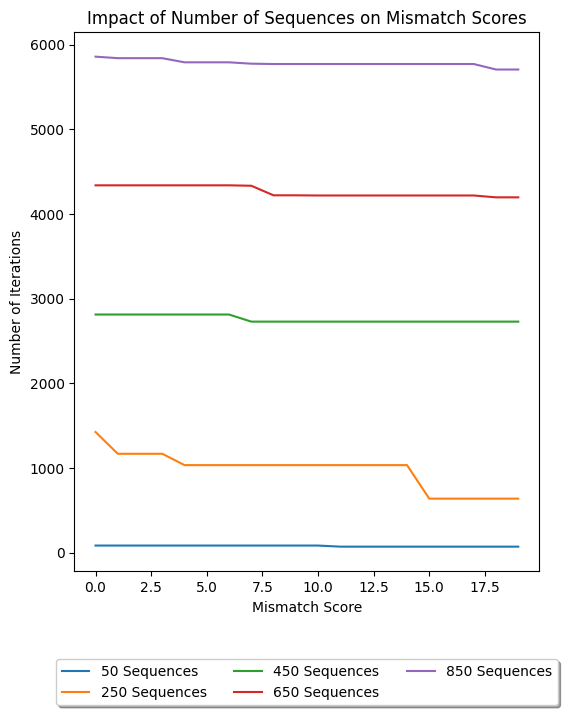


Number of sequences analyzed  = 50
Best score from Gibb's motifs = 72
Best score from real motifs = 72
Percent Correctly Identified= 98.0 % 
number of correct 49  wrong: 1

Number of sequences analyzed  = 250
Best score from Gibb's motifs = 639
Best score from real motifs = 373
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 250

Number of sequences analyzed  = 450
Best score from Gibb's motifs = 2730
Best score from real motifs = 675
Percent Correctly Identified= 0.44 % 
number of correct 2  wrong: 448

Number of sequences analyzed  = 650
Best score from Gibb's motifs = 4198
Best score from real motifs = 962
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 650

Number of sequences analyzed  = 850
Best score from Gibb's motifs = 5517
Best score from real motifs = 1302
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 850


In [16]:
#plot the data generated for different number of sequences in a set  and print the accuracy
def plot_seq_list_size():
  f = plt.figure()
  f.set_figwidth(6)
  f.set_figheight(7)
  seq_list_size_lab = []
  scores = []
  for i, j, k, l, m, n in results_seq_list_size:
    label = str(i) + " Sequences"
    seq_list_size_lab.append(label)
    scores.append(l)

  s = range(0,t)


  ax_1 = plt.subplot(111)

  for score, l in zip(scores, seq_list_size_lab):
    plt.plot(s, score, label = l)
  plt.title('Impact of Number of Sequences on Mismatch Scores')
  plt.xlabel("Mismatch Score")
  plt.ylabel("Number of Iterations", rotation = 90)
  ax_1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
  #plt.legend()
  plt.show()

plot_seq_list_size()

for num, best_motifs, positions, scores, mut_motifs, motif_pos in results_seq_list_size:
  print("\nNumber of sequences analyzed  =", num)
  print("Best score from Gibb's motifs =", mismatch_score(best_motifs))
  print("Best score from real motifs =", mismatch_score(mut_motifs))


  correct = 0
  wrong = 0

  for i in range(len(mut_motifs)):

    if mut_motifs[i] == best_motifs[i]:
      correct+=1


    else:
      wrong+=1


  print("Percent Correctly Identified=", round((1-wrong/len(mut_motifs)) *100 ,2), "%", "\nnumber of correct", correct, " wrong:", wrong)

In [ ]:
#Run Gibbs sampler for different sequence lengths
def test_seq_length(N, t):
  seq_list = vary_seq_length()
  results = []
  for i, seqs, mut_motifs, pos in seq_list:
    l = len(mut_motifs[0])
    motifs, positions, scores= run_gibbs_sampler(seqs,l, N, t)
    results.append((i, motifs, positions, scores, mut_motifs, pos))
  return results

results_seq_length = test_seq_length(N, t )


50
150
250
350
450
550


In [ ]:
#plot the data generated for different sequence length and print the accuracy

def plot_seq_length():
  seq_length_lab = []
  scores = []
  for i, j, k, l, m, n in results_seq_length:
    label = str(i) + " Sequences"
    seq_length_lab.append(label)
    scores.append(l)

  s = range(0,t)

  ax_1 = plt.subplot(111)

  for score, l in zip(scores, seq_length_lab):
    plt.plot(s, score, label = l)
  plt.title('Impact of Length of Sequences on Mismatch Scores')
  plt.xlabel("Mismatch Score")
  plt.ylabel("Number of Iterations", rotation = "horizontal")
  ax_1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
  #plt.legend()
  plt.show()

plot_seq_length()

for num, best_motifs, positions, scores, mut_motifs, motif_pos in results_seq_length:
  print("\nLegnth of the sequences analyzed  =", num)
  print("Best score from Gibb's motifs =", mismatch_score(best_motifs))
  print("Best score from real motifs =", mismatch_score(mut_motifs))


  correct = 0
  wrong = 0

  for i in range(len(mut_motifs)):

    if mut_motifs[i] == best_motifs[i]:
      correct+=1


    else:
      wrong+=1


  print("Percent Correctly Identified=", (1-wrong/len(mut_motifs)) *100 , "%", "\nnumber of correct", correct, " wrong:", wrong)


In [19]:
def test_motif_length(N, t):
  seq_list = vary_motif_length()
  results = []
  for i, seqs, mut_motifs, pos in seq_list:
    l = len(mut_motifs[i])
    motifs, positions, scores= run_gibbs_sampler(seqs,l, N, t)
    results.append((i, motifs, positions, scores, mut_motifs, pos))
  return results

results_motif_length = test_motif_length(N, t )


4
8
12
16
20


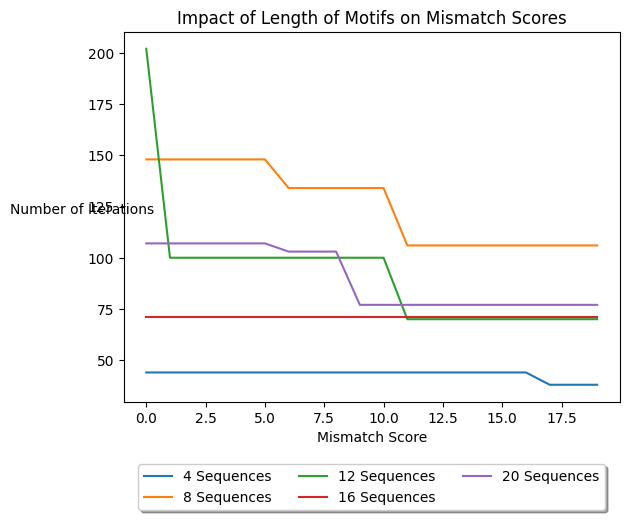


Length of the motifs = 4
Best score from Gibb's motifs = 38
Best score from real motifs = 81
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 50

Length of the motifs = 8
Best score from Gibb's motifs = 106
Best score from real motifs = 74
Percent Correctly Identified= 0.0 % 
number of correct 0  wrong: 50

Length of the motifs = 12
Best score from Gibb's motifs = 70
Best score from real motifs = 70
Percent Correctly Identified= 98.0 % 
number of correct 49  wrong: 1

Length of the motifs = 16
Best score from Gibb's motifs = 71
Best score from real motifs = 71
Percent Correctly Identified= 100.0 % 
number of correct 50  wrong: 0

Length of the motifs = 20
Best score from Gibb's motifs = 77
Best score from real motifs = 77
Percent Correctly Identified= 100.0 % 
number of correct 50  wrong: 0


In [20]:
 #plot the data generated for different motifs length and print the accuracy

def plot_motif_length():
  motif_len_lab = []
  scores = []
  for i, j, k, l, m, n in results_motif_length:
    label = str(i) + " Sequences"
    motif_len_lab.append(label)
    scores.append(l)

  s = range(0,t)


  ax_1 = plt.subplot(111)

  for score, l in zip(scores, motif_len_lab):
    plt.plot(s, score, label = l)
  plt.title('Impact of Length of Motifs on Mismatch Scores')
  plt.xlabel("Mismatch Score")
  plt.ylabel("Number of Iterations", rotation = 0)
  ax_1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
  #plt.legend()
  plt.show()

plot_motif_length()

for num, best_motifs, positions, scores, mut_motifs, motif_pos in results_motif_length:
  print("\nLength of the motifs =", num)
  print("Best score from Gibb's motifs =", mismatch_score(best_motifs))
  print("Best score from real motifs =", mismatch_score(mut_motifs))

  # print()
  # print("Best Pick", "   Correct/Wrong", "  Real Motif")
  correct = 0
  wrong = 0

  for i in range(len(mut_motifs)):

    if mut_motifs[i] == best_motifs[i]:
      correct+=1

      # if i < 5:
      #     print(best_motifs[i],"       Correct     ", mut_motifs[i] )

    else:
      wrong+=1
      # if i < 5:
      #   print(best_motifs[i], "      Incorrect    ", mut_motifs[i])


  print("Percent Correctly Identified=", round((1-wrong/len(mut_motifs)) *100, 2), "%", "\nnumber of correct", correct, " wrong:", wrong)


## Run TAIR10 Short and Long Sequences

In [ ]:
short_seqs = list(seq_df_merged["SEQUENCE_y"])
long_seqs = list(seq_df_merged["SEQUENCE_x"])
tata_seqs = list(seq_df_merged["TATA Sequence"])
motif_pos = list(seq_df_merged["POSITION OF TATA"])


short_best_motifs, short_positions, short_score = run_gibbs_sampler(short_seqs,8, N, t)



In [25]:
#Print the accuracy of Gibbs algorithm for short sequences
print("Best score from Gibb's motifs", mismatch_score(short_best_motifs))
print("Best score from real motifs", mismatch_score(tata_seqs))
# print("Real Motifs")
# print("Real Score:   ", mismatch_score(TATA_seqs))
print()
print("Best Pick", "   Correct/Wrong", "  Real Motif")
correct = 0
wrong = 0
for i in range(len(tata_seqs)):
  if tata_seqs[i] == short_best_motifs[i]:
    correct+=1

    if i < 10:
        print(short_best_motifs[i], "       Correct     ", tata_seqs[i])

  else:
    wrong+=1
    if i < 10:
      print(short_best_motifs[i], "      Incorrect    ", tata_seqs[i])


print("\nPercent Correctly Identified: ", (1-wrong/len(tata_seqs)) *100 , " %", "\ncorrect:", correct, "\nwrong:", wrong)

Best score from Gibb's motifs 55
Best score from real motifs 55

Best Pick    Correct/Wrong   Real Motif
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATAGATA        Correct      TATAGATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA
TATACATA        Correct      TATACATA

Percent Correctly Identified:  99.38271604938271  % 
correct: 161 
wrong: 1


In [26]:
#Evaluate Gibbs algorithm for long sequences
def run_long_seqs():
  results = []
  l = 8
  t = 20
  for N in range(2000, 10001, 2000):
    long_best_motifs, long_positions, long_score = run_gibbs_sampler(long_seqs,l, N, t)
    results.append((N, long_best_motifs, long_positions, long_score))
  return results

long_seq_results = run_long_seqs()


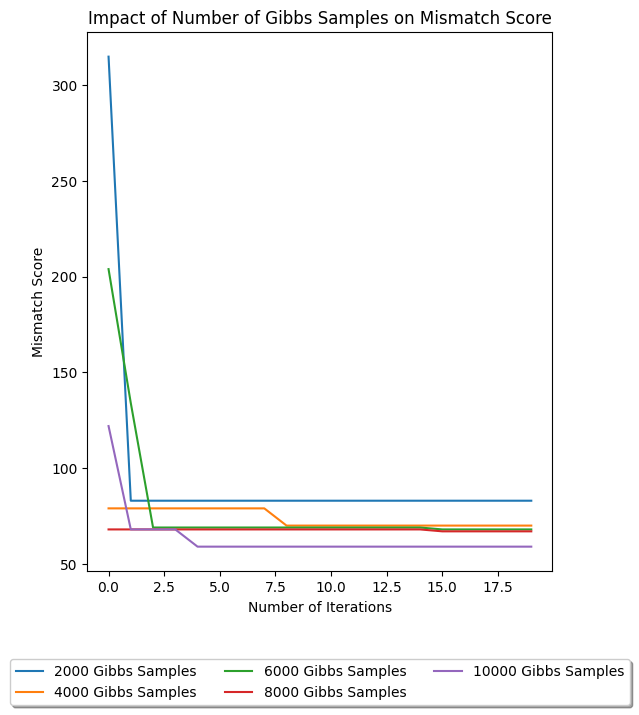

Best score from real motifs 55

Best score from Gibb's motifs 83
Percent Correctly Identified:  77.16 % 
correct: 125 
wrong: 37

Best score from Gibb's motifs 70
Percent Correctly Identified:  87.04 % 
correct: 141 
wrong: 21

Best score from Gibb's motifs 68
Percent Correctly Identified:  84.57 % 
correct: 137 
wrong: 25

Best score from Gibb's motifs 67
Percent Correctly Identified:  83.95 % 
correct: 136 
wrong: 26

Best score from Gibb's motifs 59
Percent Correctly Identified:  91.36 % 
correct: 148 
wrong: 14


In [27]:
#plot the results of Gibbs sampler for long sequences
def plot_long_seq_results():
  f = plt.figure()
  f.set_figwidth(6)
  f.set_figheight(7)
  num_mut_lab = []
  scores = []
  for i, j, k, l in long_seq_results:
    label = str(i) + " Gibbs Samples"
    num_mut_lab.append(label)
    scores.append(l)

  s = range(0,20)


  ax_1 = plt.subplot(111)

  for score, l in zip(scores, num_mut_lab):
    plt.plot(s, score, label = l)
  plt.title('Impact of Number of Gibbs Samples on Mismatch Score')
  plt.xlabel("Number of Iterations")
  plt.ylabel("Mismatch Score", rotation = 90)
  ax_1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
  #plt.legend()
  plt.show()
plot_long_seq_results()


#print the accuracy for long sequences

print("Best score from real motifs", mismatch_score(tata_seqs))
for num_samples, best_motifs, positions, score in long_seq_results:
  print("\nBest score from Gibb's motifs", mismatch_score(best_motifs))

  # print()
  # print("Best Pick", "   Correct/Wrong", "  Real Motif")
  correct = 0
  wrong = 0
  for i in range(len(tata_seqs)):
    if tata_seqs[i] == best_motifs[i]:
      correct+=1

      # if i < 5:
      #     print(best_motifs[i],"       Correct     ", tata_seqs[i] )

    else:
      wrong+=1
      # if i < 5:
      #   print(best_motifs[i], "      Incorrect    ", tata_seqs[i])


  print("Percent Correctly Identified: ", str(round((1-wrong/len(tata_seqs)) *100, 2)) , "%", "\ncorrect:", correct, "\nwrong:", wrong)